## Dacon 9회 펀다 상점매출예측 모델링 경진대회
## DB분석가(이건희, 최종승)

## 1. 라이브러리 및 데이터
## Library & Data

- 시계열 모델링을 간편하게 하기 위해 R의 forecast, forecastHybrid 패키지를 사용합니다.
- R패키지를 사용하기 위해 rpy2 파이썬 패키지를 설치합니다.
- rpy2는 pip으로 설치하면 오류가 발생하므로 Anaconda Prompt창에서 conda install -c r rpy2 명령어로 설치하시기 바랍니다.
- Numpy: 1.18.2          
- Pandas: 0.25.1         
- pmdarima: 1.5.3        
- seaborn: 0.9.0         
- statsmodel: 0.11.1     
- matplotlib: 3.1.1      
- rpy2: 2.9.4            

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pmdarima as pm
import pmdarima
import statsmodels
import rpy2
import rpy2.robjects as robjects  ##R 함수를 쓰기위함
from tqdm import tqdm
from rpy2.robjects import pandas2ri ##pandas를 R 데이터로 형식으로 변환하기 위함
from rpy2.robjects.packages import importr #R 패키지를 import
from pmdarima.arima.stationarity import ADFTest #단위근검정 ADF_TEST
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #AR값을 정하기위한 acf,pcaf
import warnings

warnings.filterwarnings("ignore")

print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
print('pmdarima: %s'%(pmdarima.__version__))
print('seaborn: %s'%(sns.__version__))
print('statsmodel: %s'%(statsmodels.__version__))
print('matplotlib: %s'%(matplotlib.__version__))
print('rpy2: %s'%(rpy2.__version__))

ModuleNotFoundError: No module named 'rpy2'

In [4]:
utils = importr('utils') ##utils 패키지를 import
utils.install_packages('forecast') ##R의 forecast패키지를 설치한다.
utils.install_packages('forecastHybrid') #R의 forecastHybrid패키지 설치

From cffi callback <function _consolewrite_ex at 0x000002D60E4905E0>:
Traceback (most recent call last):
  File "C:\Users\YoungMin\anaconda3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\YoungMin\anaconda3\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 47: invalid start byte
From cffi callback <function _consolewrite_ex at 0x000002D60E4905E0>:
Traceback (most recent call last):
  File "C:\Users\YoungMin\anaconda3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\YoungMin\anaconda3\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.str

R[write to console]: trying URL 'https://cran.seoul.go.kr/bin/windows/contrib/4.1/forecast_8.15.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2342017 bytes (2.2 MB)

R[write to console]: downloaded 2.2 MB




package 'forecast' successfully unpacked and MD5 sums checked


R[write to console]: Warning:
R[write to console]:  cannot remove prior installation of package 'forecast'

R[write to console]: Warning:
R[write to console]:  restored 'forecast'




The downloaded binary packages are in
	C:\Users\YoungMin\AppData\Local\Temp\Rtmpq0qczi\downloaded_packages


From cffi callback <function _consolewrite_ex at 0x000002D60E4905E0>:
Traceback (most recent call last):
  File "C:\Users\YoungMin\anaconda3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\YoungMin\anaconda3\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 47: invalid start byte
R[write to console]: trying URL 'https://cran.seoul.go.kr/bin/windows/contrib/4.1/forecastHybrid_5.0.19.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 680361 bytes (664 KB)

R[write to console]: downloaded 664 KB




package 'forecastHybrid' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\YoungMin\AppData\Local\Temp\Rtmpq0qczi\downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x000002D60E4F7280> [RTYPES.NILSXP]

In [6]:
pandas2ri.activate() ##모델링시 판다스를 R 데이터로 변환하기위해 activate 시켜야함
train = pd.read_csv('funda_train.csv')
submission = pd.read_csv('submission.csv')

In [7]:
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

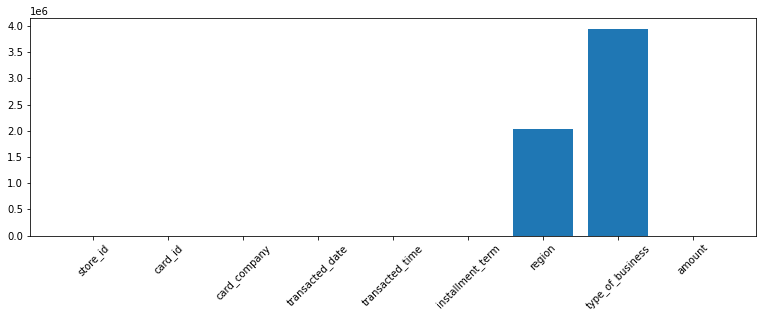

In [8]:
plt.figure(figsize=(13, 4))
plt.bar(train.columns, train.isnull().sum())
plt.xticks(rotation=45)

In [9]:
train=train.drop(['region','type_of_business'],axis=1)
train = train.iloc[0:50000]
train

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
0,0,0,b,2016-06-01,13:13,0,1857.142857
1,0,1,h,2016-06-01,18:12,0,857.142857
2,0,2,c,2016-06-01,18:52,0,2000.000000
3,0,3,a,2016-06-01,20:22,0,7857.142857
4,0,4,c,2016-06-02,11:06,0,2000.000000
...,...,...,...,...,...,...,...
49995,15,42461,d,2017-07-07,20:54,0,6428.571429
49996,15,42462,a,2017-07-07,20:56,0,7285.714286
49997,15,42463,b,2017-07-07,22:08,0,4571.428571
49998,15,42022,a,2017-07-07,22:10,0,4428.571429


In [10]:
train[train['amount']<0]

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
41,0,40,a,2016-06-10,17:26,2,-8571.428571
347,0,285,a,2016-08-04,17:52,0,-1857.142857
731,0,473,g,2016-10-17,10:32,0,-2000.000000
831,0,230,b,2016-11-03,15:36,0,-85.714286
944,0,138,a,2016-11-28,13:21,0,-57.142857
...,...,...,...,...,...,...,...
47437,15,40353,f,2017-02-09,23:36,0,-4285.714286
48086,15,40884,d,2017-03-19,01:43,0,-3857.142857
49329,15,41911,c,2017-05-29,21:15,0,-7142.857143
49653,15,40180,g,2017-06-17,01:08,0,-6714.285714


## 2. 데이터 전처리
## Data Cleansing & Pre-Processing

* 매출액에 음수 값이 보이고, 환불은 금액으로 예상됨
* 환불은 log 정규화를 했을때 무한대가 나오기 때문에 제거 하기로 결정
* 환불발생 이전 데이터 중 카드아이디가 같고 환불액의 절대값이 같은 후보 리스트를 찾음
* 환불 후보리스트 중 가장 최근시간(max)을 제거
* 시계열 모델링을 위해 month 단위로 resampling 진행
* 상점 매출이 발생하지 월은 log 정규화시 0이 아닌 최솟값으로 대치하기 위해 2로 대치(log1=0 ,log2=0.693)
* resampling시 영업 시작전 데이터는 제거하고 시작일 부터 데이터를 유지시킴


상점 매출에 **음수 값이** 존재하는 것이 확인 되었습니다. 환불금액으로 예상됩니다.

<AxesSubplot:xlabel='amount'>

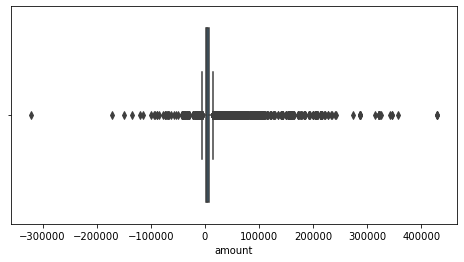

In [11]:
plt.figure(figsize=(8, 4))
sns.boxplot(train['amount'])

In [12]:
train[train['amount']<0].head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
41,0,40,a,2016-06-10,17:26,2,-8571.428571
347,0,285,a,2016-08-04,17:52,0,-1857.142857
731,0,473,g,2016-10-17,10:32,0,-2000.000000
831,0,230,b,2016-11-03,15:36,0,-85.714286
944,0,138,a,2016-11-28,13:21,0,-57.142857


In [13]:
train['datetime'] = pd.to_datetime(train.transacted_date + " " + 
                                train.transacted_time, format='%Y-%m-%d %H:%M:%S')

In [14]:
##환볼 노이즈를 제거 하는 함수
def refund_remove(df):
    refund=df[df['amount']<0]
    non_refund=df[df['amount']>0]
    remove_data=pd.DataFrame()
    
    for i in tqdm(df.store_id.unique()):
        divided_data=non_refund[non_refund['store_id']==i] ##non_refund 스토어 데이터를 스토어별로 나눔
        divided_data2=refund[refund['store_id']==i] ##refund 스토어 데이터를 나눔 스토어별로 나눔
        
        for neg in divided_data2.to_records()[:]: ##환불데이터를 차례대로 검사
            refund_store=neg['store_id']
            refund_id=neg['card_id'] ## 환불 카드 아이디
            refund_datetime=neg['datetime'] ## 환불 시간
            refund_amount=abs(neg['amount']) ## 환불액 절대값을 씌움
                
            ##환불시간 이전의 데이터중 카드이이디와 환불액이 같은 후보 리스트를 뽑는다.
            refund_pay_list=divided_data[divided_data['datetime']<=refund_datetime]
            refund_pay_list=refund_pay_list[refund_pay_list['card_id']==refund_id]
            refund_pay_list=refund_pay_list[refund_pay_list['amount']==refund_amount]
                
                
            #후보리스트가 있으면,카드아이디, 환불액이 같으면서 가장 최근시간을 제거
            if(len(refund_pay_list)!=0):
                refund_datetime=max(refund_pay_list['datetime']) ##가장 최근 시간을 구한다
                remove=divided_data[divided_data['datetime']==refund_datetime] ##가장 최근시간
                remove=remove[remove['card_id']==refund_id] ##환불 카드 아이디
                remove=remove[remove['amount']==refund_amount] ##환불액
                divided_data=divided_data.drop(index=remove.index) #인덱스를 통해 제거
                    
        ##제거한데이터를 데이터프레임에 추가한다.
        remove_data=pd.concat([remove_data,divided_data],axis=0)
    
    return remove_data

##월별로 다운 샘플링해주는 함수
def month_resampling(df):
    new_data=pd.DataFrame() 
    df['year_month']=df['transacted_date'].str.slice(stop=7)
    year_month=df['year_month'].drop_duplicates()
    
    downsampling_data=df.groupby(['store_id', 'year_month']).amount.sum()
    downsampling_data=pd.DataFrame(downsampling_data)
    downsampling_data=downsampling_data.reset_index(drop=False,inplace=False)
    
    for i in tqdm(df.store_id.unique()):
        store=downsampling_data[downsampling_data['store_id']==i]
        start_time=min(store['year_month'])
        store=store.merge(year_month,how='outer')
        store=store.sort_values(by=['year_month'], axis=0, ascending=True) ##데이터를 시간순으로 정렬
        
        store['amount']=store['amount'].fillna(2)   #매출이 발생하지 않는 월은 2로 채움
        store['store_id']=store['store_id'].fillna(i) #store_id 결측치 채운다.
        store=store[store['year_month']>=start_time]  #매출 시작일 이후만 뽑는다.
        
        new_data=pd.concat([new_data,store],axis=0)
        
    return new_data

##상점 매출 시계열 그래프
def store_plot(data,start_id,end_id):
    plt.figure(figsize=(15, 6))
    for i in data['store_id'].unique()[start_id:end_id]:
        plt.plot(data[data['store_id']== i].index, data[data['store_id'] == i].amount, label='store_{}'.format(i))
    plt.legend()   

##상점 매출 분포
def store_displot(data,start_id,end_id):
    plt.figure(figsize=(15, 6))
    for i in data.store_id.unique()[start_id:end_id]:
        sns.distplot(data[data.store_id == i].amount)
    plt.grid()
    plt.show()
    
##ARIMA 모형의 차분 여부를 결정하기 위한 단위근 검정
def adf_test(y):
    adf_test = ADFTest(alpha=0.05)
    p_val, should_diff = adf_test.should_diff(y)
    return p_val

##Series 데이터로 변환 함수
def time_series(df,i):
    store=df[df['store_id']==i]
    index=pd.date_range(min(store['year_month']),'2019-03',freq='BM') ##영업 시작일부터 2019년 2월까지 데이터가 존제
    ts=pd.Series(store['amount'].values,index=index)
    return ts

##acf. pacf 그래프
def acf_pacf_plot(data=None,store_id=None):
    ts=time_series(data,store_id)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    plot_acf(ts,lags=20,ax=ax1)
    ax2 = fig.add_subplot(212)
    plot_pacf(ts, lags=20, ax=ax2)

##매출 변동계수를 구하는 함수
def coefficient_variation(df,i):
    cv_data=df.groupby(['store_id']).amount.std()/df.groupby(['store_id']).amount.mean()
    cv=cv_data[i]
    return cv

In [15]:
train_remove=refund_remove(train)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.57it/s]


환불금액인 **음수값**이 제거 되었었습니다.

<AxesSubplot:xlabel='amount'>

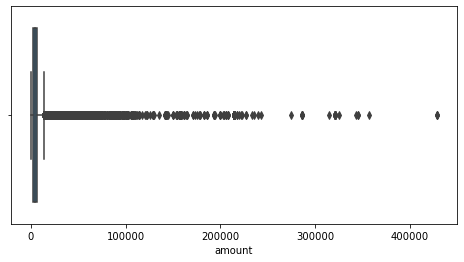

In [16]:
plt.figure(figsize=(8, 4))
sns.boxplot(train_remove['amount'])

In [17]:
train_remove.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00


In [18]:
store_count=len(train_remove.store_id.unique())
len(train_remove[train_remove['datetime']>="2018-12-01"])//store_count

380

In [19]:
##월별로 데이터 다운샘플링 시행 
resampling_data=month_resampling(train_remove)
resampling_data['store_id']=resampling_data['store_id'].astype(int)
pd.set_option('display.float_format', '{:.2f}'.format)
resampling_data

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 83.89it/s]


,store_id,year_month,amount
0,0,2016-06,747000.00
1,0,2016-07,1005000.00
2,0,2016-08,869714.29
3,0,2016-09,897857.14
4,0,2016-10,835428.57
...,...,...,...
28,15,2018-10,2.00
29,15,2018-11,2.00
30,15,2018-12,2.00
31,15,2019-01,2.00


In [20]:
col=['store_id','datetime','amount']
train_remove.loc[:,col]

,store_id,datetime,amount
0,0,2016-06-01 13:13:00,1857.14
1,0,2016-06-01 18:12:00,857.14
2,0,2016-06-01 18:52:00,2000.00
3,0,2016-06-01 20:22:00,7857.14
4,0,2016-06-02 11:06:00,2000.00
...,...,...,...
49995,15,2017-07-07 20:54:00,6428.57
49996,15,2017-07-07 20:56:00,7285.71
49997,15,2017-07-07 22:08:00,4571.43
49998,15,2017-07-07 22:10:00,4428.57


In [21]:
print(type(resampling_data))

<class 'pandas.core.frame.DataFrame'>


In [22]:
store_1=time_series(resampling_data,1)
print(type(store_1))

<class 'pandas.core.series.Series'>


In [23]:
store_0=time_series(resampling_data,0)
store_0

2016-06-30    747000.00
2016-07-29   1005000.00
2016-08-31    869714.29
2016-09-30    897857.14
2016-10-31    835428.57
2016-11-30    697000.00
2016-12-30    761857.14
2017-01-31    585642.86
2017-02-28    794000.00
2017-03-31    720257.14
2017-04-28    685285.71
2017-05-31    744428.57
2017-06-30    682000.00
2017-07-31    728285.71
2017-08-31    749000.00
2017-09-29    840857.14
2017-10-31    600571.43
2017-11-30    630857.14
2017-12-29    812714.29
2018-01-31    643142.86
2018-02-28    685285.71
2018-03-30    848428.57
2018-04-30    636142.86
2018-05-31    686428.57
2018-06-29    707285.71
2018-07-31    758714.29
2018-08-31    679857.14
2018-09-28    651857.14
2018-10-31    739000.00
2018-11-30    676000.00
2018-12-31    874571.43
2019-01-31    682857.14
2019-02-28    515285.71
Freq: BM, dtype: float64

<AxesSubplot:>

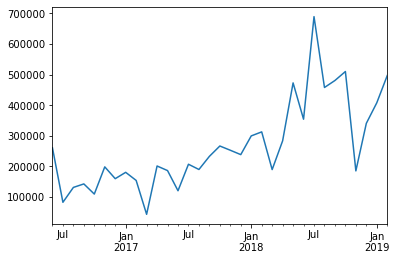

In [24]:
store_2=time_series(resampling_data,2)
store_2.plot()

<AxesSubplot:>

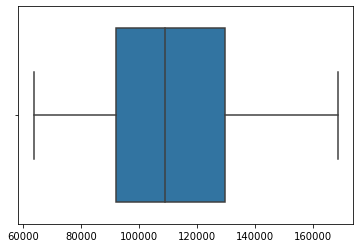

In [25]:
sns.boxplot(store_1)

## 3. 탐색적 자료분석
## Exploratory Data Analysis

* 상점마다 매출 특성과 분포가 다름
* 각 상점 매출액 ADF-Test를 boxplot 한 결과 0.05이상으로 차분이 필요해 보임
* acf, pcaf 그래프를 보면 대부분의 상점의 적정 ar값이 2이하로 보임
* auto_arima 파라미터 튜닝시 max.p 값을 2로 고정, d값은 ndiffs함수로 구함

각 상점별 **매출 특성**과 **분포**가 다르므로 개별적인 시계열 모델링이 필요해 보입나다.

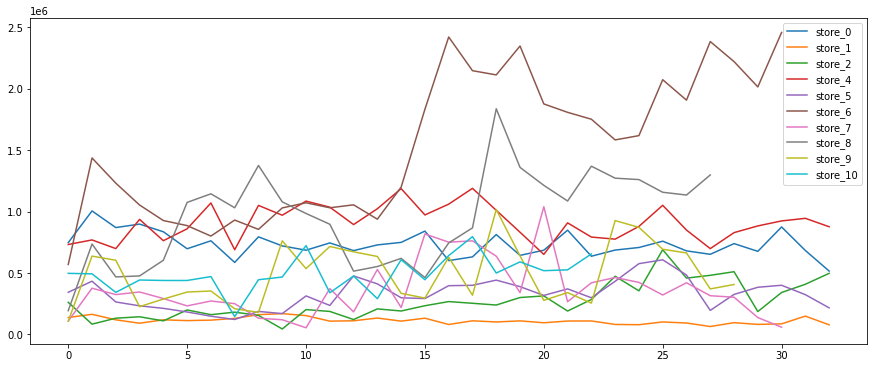

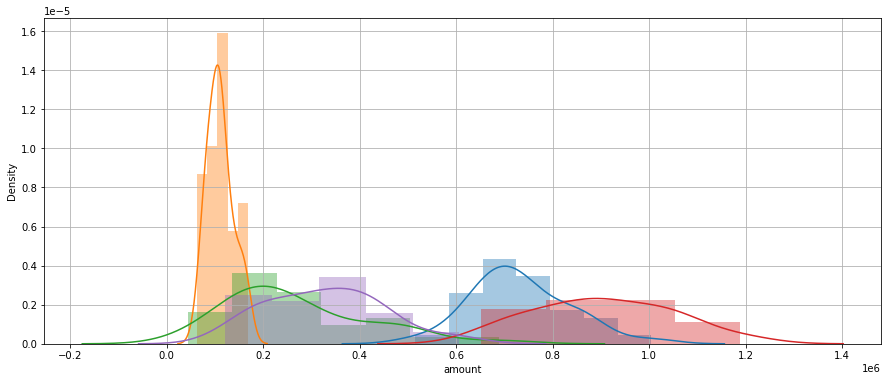

In [26]:
##store의 시계열 plot과 distplot
store_plot(resampling_data,0,10)
store_displot(resampling_data,0,5)

귀무가설(H0): 자료에 **단위근**이 존재한다.<br>
대립가설(H1): 시계열 자료가 **정상성**을 만족한다(또는 추세 정상성을 만족한다)<br>
대부분 상점들의 **p-value**값이 **0.05**보다 높으므로 **귀무가설**이 채택되고 시계열 자료의 **정상성**을 만족하기 시키기 위해 **차분**이 필요해 보입니다.



100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 117.06it/s]


<AxesSubplot:>

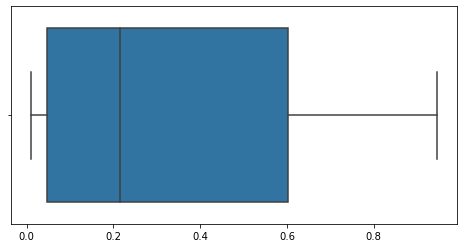

In [27]:
##전체 상점 adf_test p-value값을 계산하여 boxplot
adf_p=[]
for i in tqdm(resampling_data['store_id'].unique()):
    ts=time_series(resampling_data,i)
    adf_p.append(adf_test(ts))
    
plt.figure(figsize=(8, 4))    
sns.boxplot(adf_p)

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 20 must be < 16.

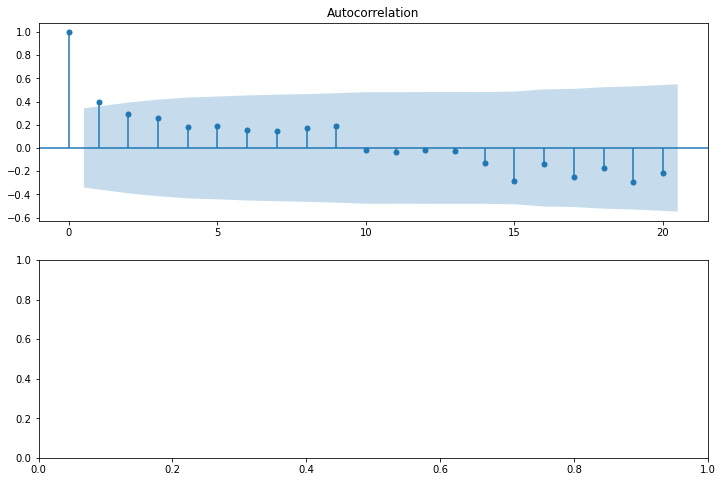

In [28]:
##상점별로 acf, pacf 그래프 확인
acf_pacf_plot(data=resampling_data,store_id=1)

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling

* 시계열 모델로 모델링을 진행 하기 때문에 연도-월 변수와 매출액 변수만 유지
* 모델링을 할때 coefficient_variation(매출 변동계수)를 고려해서 log 정규화를 진행 

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation


* 매출액 오차를 줄이기 위해 auto_arima, stl_descompostion+ets model, simple ets model을 average ensemble 진행
* auto.arima는 AIC를 최소로하는 p, d, q값을 자동적으로 탐색
* auto.arima 파라미터는 ndiffs(d값 계산)함수와 acf pcaf그래프로 max.p=2로 고정
* 최종예측은 이후 3개월을 예측하여 합산
* 매출액 변동계수가 큰 상점들에 log 정규화를 했을때 오차가 커지는 경향을 확인 (변동성이 커서 잡음제거 목적을 달성하지 못하고 매출액을 과대 예측)
* 모델링을 진행할때 CV(변동계수)값이 0.3(실험결과 오차가 가장적음)이하인 경우 log 정규화를 하기로 결정
* 충분한 시즌이 없는경우 stl descomposition+ets model을 적합하지 못하고 auto.arima와 ets를 앙상블(stl descompostion은 최소 2시즌이상 데이터 필요)


**forecastHybrid**는 앙상블 시계열 모델을 쉽게 구축 할 수 있게 해주는 패지지입니다.<br>
**robjects.r** 함수는 파이썬에서 **R의 기본 함수**와 **패키지**를 쓸수 있게 도와주고 **str**형식으로 정의된 **R function**도 사용이 가능하게  해줍니다. 

In [39]:
##auto_arima,stl_descompostion+ets,simple ets model ensemble
hybridModel="""
    function(testdata){
        library(forecast)
        library(forecastHybrid)
        d_params=ndiffs(testdata)
        hb_mdl<-hybridModel(testdata,models="aes",
                        a.arg=list(max.p=2,d=d_params),weight="equal")
        forecasted_data<-forecast(hb_mdl,h=3) ##이후 3개월(h=3)을 예측
        outdf<-data.frame(forecasted_data$mean)
        colnames(outdf)<-c('amount')
        outdf
    }
"""

#사용할 R 함수
hybridModel=robjects.r(hybridModel)
ts=robjects.r('ts')
c=robjects.r('c')
log=robjects.r('log')
exp=robjects.r('exp')

final_pred=[]
for i in tqdm(resampling_data.store_id.unique()):
    pred=[]
    
    store=resampling_data[resampling_data['store_id']==i]
    start_year=int(min(store['year_month'])[:4]) ##영업 시작 년도
    start_month=int(min(store['year_month'])[5:]) ##영업 시작 월
    
    cv=coefficient_variation(resampling_data,i)
    ##매출액 변동계수가 0.3이하인 경우만 log를 씌움
    if cv<0.3:
        data=ts(log(store['amount']),start=c(start_year,start_month),frequency=12) #R의 ts함수로 time series데이터로 변환
        ##ensemble model
        forecast=hybridModel(data)
        final_pred.append(np.sum(pandas2ri.ri2py(exp(forecast)).values)) #3개월 매출을 합산,final_pred에 추가
    ##매출액 변동계수가 0.3이상인 경우
    else:
        data=ts(store['amount'],start=c(start_year,start_month),frequency=12)
        ##ensemble model
        forecast=hybridModel(data)
        final_pred.append(np.sum(pandas2ri.ri2py(forecast).values)) #3개월 매출을 합산, final_pred에 추가  

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]


NotImplementedError: Conversion 'rpy2py' not defined for objects of type '<class 'pandas.core.frame.DataFrame'>'

In [27]:
submission['amount']=final_pred
submission.to_csv('submission.csv', index=False)
submission

,store_id,amount
0,0,1996289.71
1,1,265304.45
2,2,1240680.98
3,4,2695278.94
4,5,824062.03
...,...,...
1962,2132,2115932.99
1963,2133,631105.24
1964,2134,302129.20
1965,2135,1626442.38
